# Log

It was nice not having to do so much setup for this part. But I had to spend quite some time on exploring the Open-Meteo API, including installing the required packages for collecting the data. It took some time before I realized that I had to use the historical forecast api to get data that are older than 90 days.   

I also spent some time trying to get latitude and longitude data from the api, but I was sad to see on padlet that we had to hard code this into our code. This would have been a cool task to implement in a future version of the course, if it is easily accessible in a different api.   

For detecting outliers and anomalies, I did not have the time to dig deep into the theory behind these methods, but I think the implementation of these went fine with the help of AI.  

For the STL analysis and spectrogram I also did not have time to dig into the theory, and here I am a bit more unsure if the produced plots are correct, even with the help of AI.  

When making the new version of the Streamlit app I kept the original naming of the pages, but they are in the new order. I think this is a bit weird. Were we supposed to rename these after we had done the reordering?   

It was fun to add session_state to the app and see that using this the selections and data will be available for other pages to use. I think the selector we were supposed to make was only for the year. But I figured it would be a nice touch to add selector for city as well, since we collected the longitude and latitude for each city at the beginning of the first task.   

For the plots I reused the code from the plots produced in the jupyter notebook.


# AI use

As mentioned above I relied heavily on AI for the 4 plots we had to make. I used ChatGPT and asked quite generally for it to produce the plots I needed. Then I made some tweaks to the parameters myself to produce plots that I think made quite ok cutoffs for identifying outliers and anomalies. For the seasonal trend and spectrogram, I did not make many tweaks myself and hope that the AI made correct choices.   

For the Streamlit task I used Claude to produce example code for how to produce tabs and example code for how to produce session state. I then expanded on this code myself to solve the task.


# Git and Streamlit
https://github.com/KristofferHemm/ind320/tree/part3   
https://ind320-part3.streamlit.app/

# Setup

In [2]:
import openmeteo_requests
import pandas as pd
import requests_cache
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import os
from scipy.signal import stft
from datetime import timedelta, date, datetime
from retry_requests import retry
from scipy.fft import dct, idct
from sklearn.neighbors import LocalOutlierFactor
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from dotenv import load_dotenv
from pyspark.sql import SparkSession, functions
from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess

# Silence warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('cassandra').setLevel(logging.CRITICAL)

# Make plotly plots appear in the pdf
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
# Setting the environment for PySpark
load_dotenv()

HADOOP_PATH = os.getenv("HADOOP_PATH")

os.environ["JAVA_HOME"] = r"C:\Program Files\Microsoft\jdk-11.0.28.6-hotspot" 
os.environ["PYSPARK_HADOOP_VERSION"] = "without"
os.environ["HADOOP_HOME"] = HADOOP_PATH
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"

In [3]:
# Setup for the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [4]:
# Create dataframe with cities
cities = {
    'Oslo':
        {"price_area_code": "NO1",
         "longitude": 10.7461,
         "latitude": 59.9127
        },
    'Kristiansand':
        {"price_area_code": "NO2",
         "longitude": 7.9956,
         "latitude": 58.1467
        },
    'Trondheim':
        {"price_area_code": "NO3",
         "longitude": 10.3951,
         "latitude": 63.4305        
        },
    'Tromsø':
        {"price_area_code": "NO4",
         "longitude": 18.9551,
         "latitude": 69.6489        
        },
    'Bergen':
        {"price_area_code": "NO5",
         "longitude": 5.3242,
         "latitude": 60.393        
        }
    }
df_hourly = pd.DataFrame(cities)

In [5]:
df_hourly

,Oslo,Kristiansand,Trondheim,Tromsø,Bergen
price_area_code,NO1,NO2,NO3,NO4,NO5
longitude,10.7461,7.9956,10.3951,18.9551,5.3242
latitude,59.9127,58.1467,63.4305,69.6489,60.393


# Collecting data

In [6]:
def create_dates(year):
    """
    Creates date for a given input year
    """
    start = f'{year}-01-01'
    end = f'{year}-12-31'
    return start, end

In [7]:
def fetch_data(longitude, latitude, year):
    """
    Fetch data from meteo based on longitude, latitude and year

    """
    start, end = create_dates(year)
    params = {
	"latitude": latitude,
	"longitude": longitude,
    "start_date": start,
    "end_date": end,
	"hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_gusts_10m", "wind_direction_10m"],
    }
    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    responses = openmeteo.weather_api(url, params=params)
    return responses

In [8]:
# Collect data for Bergen in 2019
year = 2019
responses = fetch_data(df_hourly.Bergen.longitude, df_hourly.Bergen.latitude, year)

In [9]:
# Process the data as given in the meteo documentation
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

df_hourly = pd.DataFrame(data = hourly_data)

Coordinates: 60.390037536621094°N 5.3183135986328125°E
Elevation: 17.0 m asl
Timezone difference to GMT+0: 0s


In [10]:
# Check that we get data in a dataframe
df_hourly.head()

,date,temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m
0,2019-01-01 00:00:00+00:00,5.772,0.2,41.036842,107.279991,277.561340
1,2019-01-01 01:00:00+00:00,6.072,0.7,42.033756,111.959999,286.417297
2,2019-01-01 02:00:00+00:00,6.322,0.5,40.913490,105.839996,298.368958
3,2019-01-01 03:00:00+00:00,5.822,1.1,41.238468,110.159996,315.000092
4,2019-01-01 04:00:00+00:00,5.722,0.7,44.140755,107.279991,322.288879


In [11]:
df_hourly.dtypes

date                  datetime64[ns, UTC]
temperature_2m                    float32
precipitation                     float32
wind_speed_10m                    float32
wind_gusts_10m                    float32
wind_direction_10m                float32
dtype: object

# Plotting

## Raw temperature

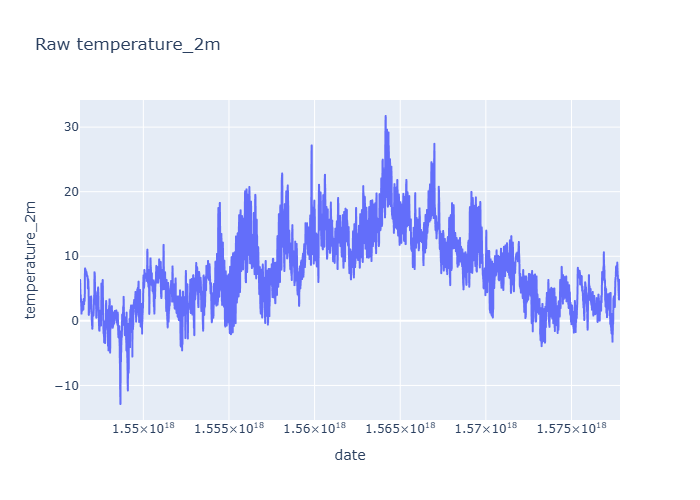

In [12]:
# Raw plot of temperature over time
fig = px.line(df_hourly, x="date", y="temperature_2m", title='Raw temperature_2m')
fig.show()

## Seasonally adjusted temperature variations

In [13]:
def plot_summary_satv(df, cutoff=100, k=3.0):
    """
    Input:
    df : pd.DataFrame
    cutoff : int
    k : float

    Returns
    -------
    fig : plotly.graph_objects.Figure
    summary : pd.DataFrame
    """

    df = df.copy()

    # High pass filtering
    temp_dct_ortho = dct(df['temperature_2m'], norm='ortho')
    temp_dct_ortho[:cutoff] = 0
    df['temp_highpass'] = idct(temp_dct_ortho, norm='ortho')
    df['seasonal'] = df['temperature_2m'] - df['temp_highpass']

    # Seasonally adjusted temperature variations
    median_satv = np.median(df['temp_highpass'])
    mad_satv = np.median(np.abs(df['temp_highpass'] - median_satv))
    upper_satv = median_satv + k * mad_satv
    lower_satv = median_satv - k * mad_satv

    df['ucl'] = df['seasonal'] + upper_satv
    df['lcl'] = df['seasonal'] + lower_satv

    # Add outliers to df
    df['is_outlier'] = (df['temp_highpass'] > upper_satv) | (df['temp_highpass'] < lower_satv)

    # Plotting
    fig = go.Figure()
    
    # Original temperature_2m trace
    fig.add_trace(go.Scatter(
        x=df['date'],
        y=df['temperature_2m'],
        mode='lines',
        name='Original temperature'
    ))

    # Outliers
    fig.add_trace(go.Scatter(
        x=df.loc[df['is_outlier'], 'date'],
        y=df.loc[df['is_outlier'], 'temperature_2m'],
        mode='markers',
        name='Outliers',
        marker=dict(color='red', size=4, symbol='circle'),
    ))

    # SPC boundaries (horizontal lines)
    fig.add_trace(go.Scatter(
        x=df['date'],
        y=df['ucl'],
        mode='lines',
        name='UCL (Upper Control Limit)',
        line=dict(color='green', dash='dash')
    ))
    
    fig.add_trace(go.Scatter(
        x=df['date'],
        y=df['lcl'],
        mode='lines',
        name='LCL (Lower Control Limit)',
        line=dict(color='green', dash='dash')
    ))
    
    # Layout
    fig.update_layout(
        title='Temperature with SPC Outlier Detection (Seasonally Adjusted via DCT)',
        xaxis_title='Date',
        yaxis_title='Temperature (°C)',
        template='plotly_white',
        legend=dict(yanchor='top', y=0.98, xanchor='left', x=0.01),
        height=600
    )

    # Create summary
    total_points = len(df)
    n_outliers = df['is_outlier'].sum()
    outlier_pct = 100 * n_outliers / total_points

    normal_mean = df.loc[~df['is_outlier'], 'temperature_2m'].mean() if n_outliers < total_points else np.nan
    outlier_mean = df.loc[df['is_outlier'], 'temperature_2m'].mean() if n_outliers > 0 else np.nan
    outlier_max = df.loc[df['is_outlier'], 'temperature_2m'].max() if n_outliers > 0 else np.nan
    outlier_min = df.loc[df['is_outlier'], 'temperature_2m'].min() if n_outliers > 0 else np.nan
    first_outlier = df.loc[df['is_outlier'], 'date'].min() if n_outliers > 0 else np.nan
    last_outlier = df.loc[df['is_outlier'], 'date'].max() if n_outliers > 0 else np.nan

    summary = pd.DataFrame([{
        'Total Points': total_points,
        'Detected Outliers': n_outliers,
        'Outlier %': round(outlier_pct, 3),
        'Normal Mean': round(normal_mean, 3),
        'Outlier Mean': round(outlier_mean, 3),
        'Outlier Max': round(outlier_max, 3),
        'Outlier Min': round(outlier_min, 3),
        'First Outlier': first_outlier,
        'Last Outlier': last_outlier
    }])

    return fig, summary

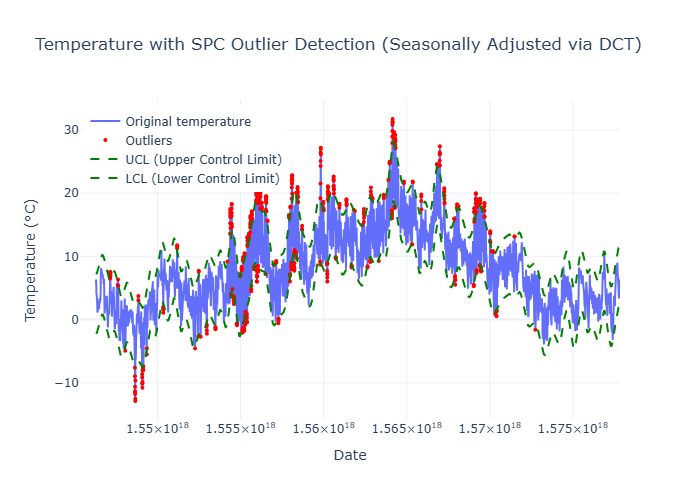

Outlier Summary:


,Total Points,Detected Outliers,Outlier %,Normal Mean,Outlier Mean,Outlier Max,Outlier Min,First Outlier,Last Outlier
0,8760,491,5.605,7.543,12.647,31.722,-12.878,2019-01-10 18:00:00+00:00,2019-11-03 00:00:00+00:00


In [14]:
fig, summary = plot_summary_satv(df_hourly)
# Show results
fig.show()
print("Outlier Summary:")
summary

##  Percipitation with anomalies identified using the local outlier factor method

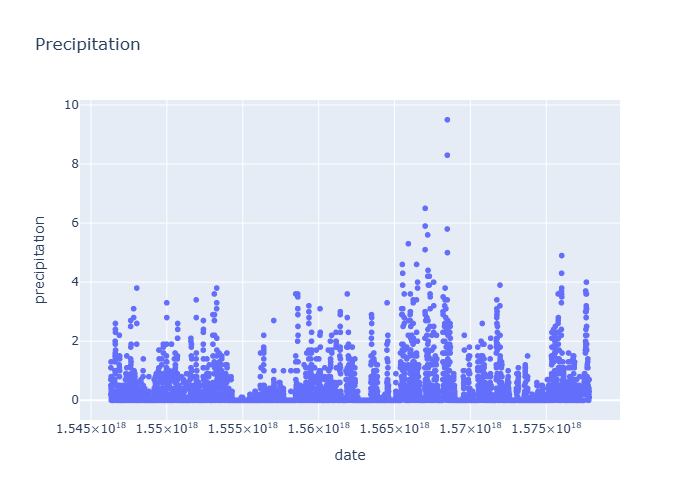

In [15]:
# Raw plot of percipitation over time
fig = px.scatter(df_hourly, x="date", y="precipitation", title='Precipitation')
fig.show()

In [16]:
def plot_summary_lof(df, outlier_fraction=0.01):
    """
    Input:
    df : pd.DataFrame
    outlier_fraction : float

    Returns
    -------
    fig : plotly.graph_objects.Figure
    summary : pd.DataFrame
    """
    
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    # Feature for anomaly detection
    X = df[["precipitation"]].values

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=outlier_fraction)
    labels = lof.fit_predict(X)
    df["anomaly"] = labels == -1
    anomalies = df[df["anomaly"]]

    # Plotting
    fig = go.Figure()

    # Normal points (blue line)
    fig.add_trace(go.Scatter(
        x=df["date"], y=df["precipitation"],
        mode="lines", name="Normal", line=dict(color="blue")
    ))

    # Anomalies (red markers)
    fig.add_trace(go.Scatter(
        x=anomalies["date"], y=anomalies["precipitation"],
        mode="markers", name="Anomaly",
        marker=dict(color="red", size=4, symbol="circle")
    ))

    fig.update_layout(
        title=f"Precipitation with Anomalies (LOF, {outlier_fraction*100:.1f}% expected outliers)",
        xaxis_title="Date-Time",
        yaxis_title="Precipitation",
        template="plotly_white",
        legend_title="Type"
    )

    # Create summary
    summary_data = {
            "Total Points": [len(df)],
            "Detected Anomalies": [len(anomalies)],
            "Anomaly %": [len(anomalies) / len(df) * 100],
            "Normal Mean": [df["precipitation"].mean()],
            "Anomaly Mean": [anomalies["precipitation"].mean()],
            "Anomaly Max": [anomalies["precipitation"].max()],
            "Anomaly Min": [anomalies["precipitation"].min()],
            "First Anomaly": [anomalies["date"].min()],
            "Last Anomaly": [anomalies["date"].max()]
        }
    summary = pd.DataFrame(summary_data)

    return fig, summary

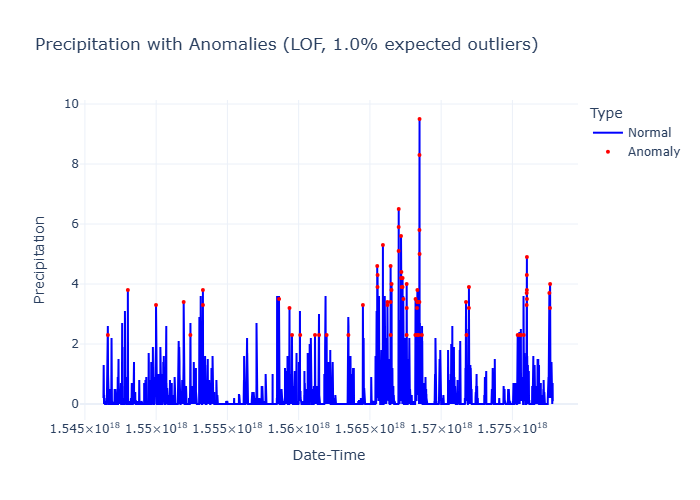

Outlier Summary:


,Total Points,Detected Anomalies,Anomaly %,Normal Mean,Anomaly Mean,Anomaly Max,Anomaly Min,First Anomaly,Last Anomaly
0,8760,72,0.821918,0.24645,3.665278,9.5,2.3,2019-01-04 15:00:00+00:00,2019-12-29 19:00:00+00:00


In [17]:
fig, summary = plot_summary_lof(df_hourly)
fig.show()
print("Outlier Summary:")
summary

## Collection data from CassandraDB using Spark

In [16]:
# Setting Cassandra environment
keyspace = 'my_first_keyspace'
table_name = 'elhub'

# Connecting to Cassandra
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()
session.set_keyspace(f'{keyspace}')

In [17]:
# Start a Spark session
spark = (
    SparkSession.builder
    .appName('CassandraReader')
    .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1')
    .config('spark.cassandra.connection.host', 'localhost')  
    .config('spark.cassandra.connection.port', '9042')
    .getOrCreate()
)

In [18]:
# Collect the data from the Cassandra database
df_no = (
    spark.read
    .format('org.apache.spark.sql.cassandra')
    .options(table='elhub', keyspace='my_first_keyspace')
    .load()
    .select('pricearea', 'productiongroup', 'starttime', 'quantitykwh')
)

In [19]:
# Convert to pandas dataframe
df_no = df_no.toPandas()
df_no.head()

,pricearea,productiongroup,starttime,quantitykwh
0,NO4,thermal,2021-12-13 22:00:00,20695.977
1,NO2,thermal,2021-08-17 23:00:00,11756.242
2,NO1,other,2021-10-02 10:00:00,2.282
3,NO5,hydro,2021-11-30 02:00:00,1583308.200
4,NO2,hydro,2021-12-05 22:00:00,8371775.000


## Seasonal-Trend decomposition of electricity production using LOESS 

In [20]:
def _make_odd(x):
    """Return an odd integer >= 3 from x (int or None)."""
    if x is None:
        return None
    x = int(x)
    if x < 3:
        return 3
    return x if x % 2 == 1 else x + 1

def loess_decompose_and_plot(
    df,
    pricearea=None,
    productiongroup=None,
    period_length=24,
    seasonal_smoother=None,
    trend_smoother=None,
    robust=False,
    resample_rule=None,
    lowess_frac=0.1,
    ):

    """
    Seasonal trend decomposition (which uses local regression / loess internally),
    and plot original series, trend, seasonal and residual components.

    Parameters:
    df : pandas.DataFrame
    pricearea=None,
    productiongroup=None,
    period_length=24,
    seasonal_smoother=None,
    trend_smoother=None,
    robust=False,
    resample_rule=None,
    lowess_frac=0.1
    
    Returns:
    fig : matplotlib.figure.Figure
    """

    # Copy the dataframe an aggregate quantities by timestamp
    df = df.copy()
    df['starttime'] = pd.to_datetime(df['starttime'])
    df = df.sort_values('starttime')
    series = df.groupby('starttime')['quantitykwh'].sum()
    series = series.sort_index()
    n = len(series)

    # Prepare STL parameters
    seasonal = _make_odd(seasonal_smoother if seasonal_smoother is not None else period_length)
    trend = _make_odd(trend_smoother if trend_smoother is not None else max(7, int(period_length * 1.5)))
    
    # Ensure seasonal < n and trend < n
    seasonal = seasonal if (seasonal is None or seasonal < n) else _make_odd(max(3, n - 2))
    trend = trend if (trend is None or trend < n) else _make_odd(max(3, n - 2))

    stl = STL(series, period=period_length, seasonal=seasonal, trend=trend, robust=robust)
    res = stl.fit()
    
    lowess_sm = lowess(series.values, np.arange(n), frac=lowess_frac, return_sorted=False)

    # Plotting
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    
    # Original series
    axes[0].plot(series.index, series.values)
    axes[0].set_ylabel('quantitykwh')
    axes[0].set_title('Original series and LOWESS overlay')
    axes[0].plot(series.index, lowess_sm, linestyle='--')
    
    # Trend
    axes[1].plot(series.index, res.trend)
    axes[1].set_ylabel('Trend')
    
    # Seasonal
    axes[2].plot(series.index, res.seasonal)
    axes[2].set_ylabel('Seasonal')
    
    # Residual
    axes[3].plot(series.index, res.resid)
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('time')
    
    
    plt.tight_layout()

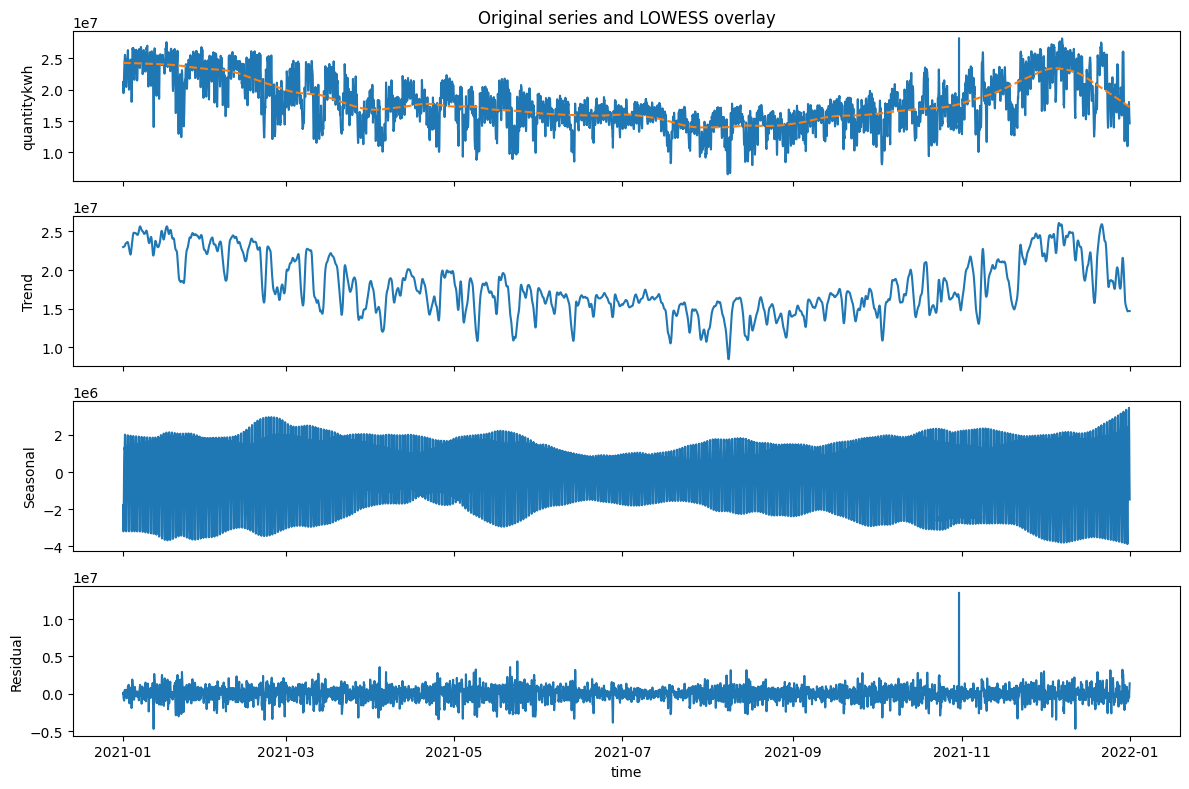

In [21]:
loess_decompose_and_plot(df_no)
plt.show()

## Spectrogram of electricity production data

In [22]:
def plot_spectrogram_stft(df, pricearea='NO1', productiongroup='hydro',
                          resample_freq='15min', window_length='2H', overlap=0.5):
    """
    Plot a spectrogram of energy production using scipy.signal.stft.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns ['starttime', 'pricearea', 'productiongroup', 'quantitykwh'].
    pricearea : str, default 'NO1'
        Filter for this price area.
    productiongroup : str, default 'Hydro'
        Filter for this production group.
    resample_freq : str, default '15min'
        Frequency to resample the data to uniform spacing.
    window_length : str, default '2H'
        Window length for STFT.
    overlap : float, default 0.5
        Overlap ratio between consecutive windows (0 < overlap < 1).

    Returns
    -------
    fig : matplotlib.figure.Figure

    """
    # Filter data
    dff = df[(df['pricearea'] == pricearea) & (df['productiongroup'] == productiongroup)].copy()
    if dff.empty:
        raise ValueError("No data for the given filters.")

    # Ensure datetime and sort
    dff['starttime'] = pd.to_datetime(dff['starttime'])
    dff.sort_values('starttime', inplace=True)
    dff.set_index('starttime', inplace=True)

    # Resample to a regular time step
    dff = dff['quantitykwh'].resample(resample_freq).mean().interpolate()
    signal = dff.values

    # Compute parameters for STFT
    fs = 1 / pd.to_timedelta(resample_freq).total_seconds()  # Sampling frequency [Hz]
    nperseg = int(pd.to_timedelta(window_length).total_seconds() / pd.to_timedelta(resample_freq).total_seconds())
    noverlap = int(nperseg * overlap)

    # Compute STFT
    f, t, Zxx = stft(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Plot spectrogram
    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='viridis')

    ax.set_title(f"Spectrogram (STFT) for {productiongroup} in {pricearea}")
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    fig.colorbar(im, ax=ax, label='|Amplitude|')

    plt.tight_layout()
    return fig

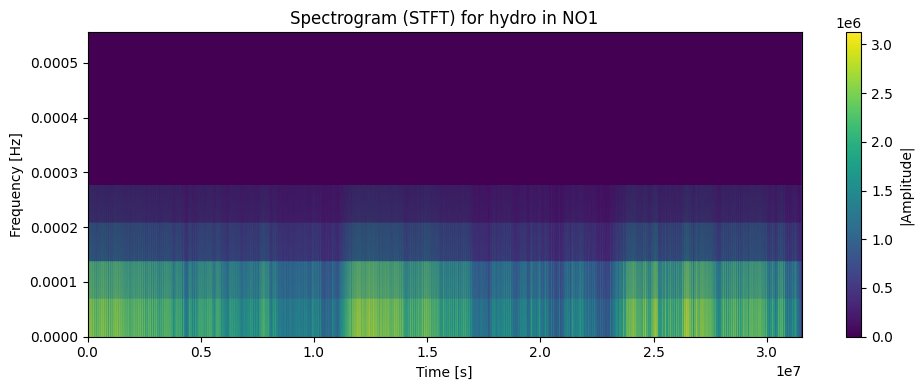

In [23]:
fig = plot_spectrogram_stft(df_no)
plt.show()